# Re-creating and explaining ResNet-34 and its architecture

## Import Dependencies

`import torch` -- Imports the PyTorch package

`from torch import nn` -- Contains all the basic building blocks for neural networks in PyTorch

`import matplotlib.pyplot as plt` -- Imports graph plotting functionality from Matplotlib the library

`torch.__version__` -- Used to check the version of PyTorch being used, helpful to see if PyTorch has been installed and correctly imported

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1'

## Resnet-34 is available in the PyTorch library with pre-trained weights to use

Documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html

However to explain its architecture in detail we will be making it from scratch

## Input

The ResNet-34 model we will build as an exmaple is going to expect an input tensor of shape [2,3,224,224].

Each dimension of this input tensor represents a piece of information about the input image.

`2`: This two represents the batch size of the input tensor, which is the number of samples (images) used in one forward and backward pass. This is an important parameter for computer vision models as a lower batch size increases the accuracy by decreasing the model's loss. If we were to train the model on all our images in one go, rather than learn patterns in the data the model would in essence just memorise the input images. Currently this has been described in layman's terms, but for more detailed information and explanations refer to the following sources: https://medium.com/geekculture/how-does-batch-size-impact-your-model-learning-2dd34d9fb1fa, https://medium.com/geekculture/why-small-batch-sizes-lead-to-greater-generalization-in-deep-learning-a00a32251a4f

`3`: This represents how many colour channels our input image has. In this scenario the input is a coloured image with 3 colour channels: Red, Green, Blue. If we were using greyscale images this value would be 1, as each pixel only has one colour value.

`224`: These two value represent the height and width of the input image.

PyTorch documentation on images: https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html

Lets now create a random tensor of the need input shape and plot it.

`permute(1,2,0)`: This code rearranges the shape of the tensor. So instead of a shape of `[3,224,224]` the image tensor will have a shape of `[224,224,3]`.

This permute is needed as although the convention in PyTorch is that the tensor consists of `[Colour channels, height, width]` other libraries instead use the convention of [Height, width, colour channel]. Although this is only a semantic difference, it is an important to note that a failure to follow the required convention for the application will lead to errors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


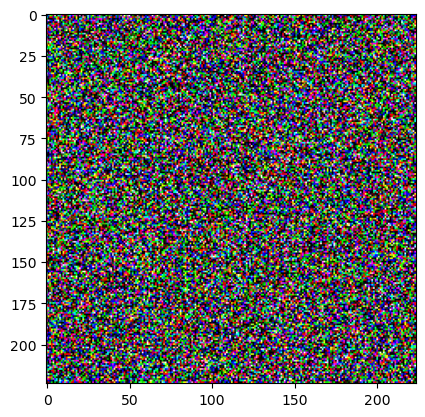

In [2]:
# Example input needed for the model

input = torch.randn(2, 3, 224, 224)

input.shape

# Plot first image and show it
image = input[0].permute(1, 2, 0)

plt.imshow(image)

## Initial Convolutional Block

Before the input data is passed through to the residual blocks that contain residual connections, it first goes through an initial convolutional block.

This block consists of 4 operations:

Convolution:

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Parameters:

`in_channels` -- number of channels of the input image, 3 since we are using an RGB image

`out_channels` -- number of channels produced by the convolution

`kernel_size`, `stride`, `padding` -- parameters for how the convolutional layer operates, refer to link below for further details

Rather than try to explain this in detail myself, please refer to the following website for explanations and visualisations of Convolutional Neural Networks and how convolutional layers work: https://poloclub.github.io/cnn-explainer/

Batch Normalization

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

This is a technique that is implemented to improve the training of a deep neural network such as ResNet-34. This addresses a fundamental problem with deep neural networks, as the training of such models causes a change to all the layers which can be seen as 'chasing a moving target'. Batch normalisation is implemented to help co-ordinate the update of all the layers, and help to stabilise the learning of the model. For more information please read the following article: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/. Find the original research paper for batch normalisation here: https://arxiv.org/abs/1502.03167

ReLU activation function

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

ReLU is a non-linear activation function that is one of the simplest layers used in PyTorch. It takes the input, and outputs whatever is greatest between the input and 0. In essence this function turns all negative values in the input into 0.

Maxpooling

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

Maxpooling is an operation that scans across the image tensor similar to a convolutional layer, however instead it takes the maximum value of a section of the image it is viewing. This method in essence condenses the image into the most distinct and important features. For more information refer to the following: https://d2l.ai/chapter_convolutional-neural-networks/pooling.html, https://poloclub.github.io/cnn-explainer/

In [3]:
conv_block = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False), #112,112
                       nn.BatchNorm2d(64),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # 56,56
conv_block

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

Both the convolutional layer and the maxpooling layer downsample the input image by half. Lets see what this entails by putting our input image through this convolutional block and printing the output shape.

In [4]:
output = conv_block(input) 

output.shape

torch.Size([2, 64, 56, 56])

## Residual Block

Now we need to implement a convolutional block. This block will perform two convolutions on the input, and then combine the output of this with initial input, creating a residual connection.

### Key Points:

`Constructor`: in this constructor we detail all the layers and functions being used in this block. Details of all the layers being used have already been covered in the initial convolutional block section. The only new thing here is the use of a downsample hyperparameter, this is used to match the shapes of the input and output being used in the residual connection addition.

`Forward pass`: Everything in the forward pass is standard apart from `out += identity`. This is the implementation of the residual connection, where the output of 2 convolutional layers is combined with the initial input. This is then passed through a ReLU function before the final output is returned.

In [5]:
class BasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

Lets now see view this BasicBlock and its architecture:

In [6]:
BasicBlock(64, 128)

BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Functionising the creation of layers

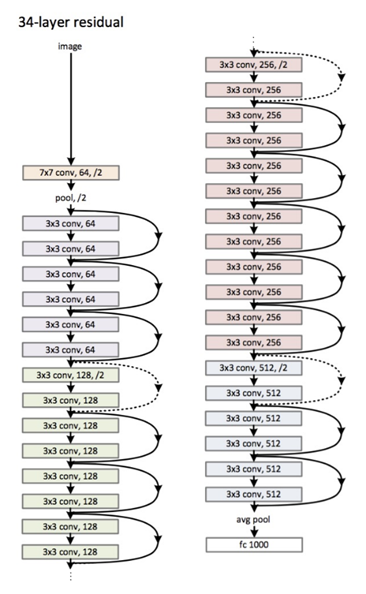

So far we have created the initial convolution layer, and built the foundation BasicBlock for our residual network. If we refer to the image above a BasicBlock consists of two of these coloured convolutional blocks with the residual connection implemented. ResNet-34 is split into 4 residual layers, as can be seen by the differing colour in the diagram (light purple, light yellow, light red, light blue). These layers consists of varying numbers of BasicBlocks, to form a total of 16 BasicBlocks and 32 convolutional layers.

As such, we are going to create a function that can make each of these denoted layers.

Lets break this code down:

`Downsampling handling section`: This handles whether the layer being made needs to include downsampling in it's blocks. We won't go into too much detail, however this essentially handles the shape of the inputs to be used in residual connections, due to the changing number of features throughout the model.

`Layer creation section`: After having determined whether downsampling is required, it is now time to create the layer. Using the hyper-parameters blocks_need we know how many BasicBlock's the layer requires, and we can then add all the necessary blocks needed to the list blocks.

`Return the layer section`: Now that we have a list of all the blocks required for the layer, we can turn this into a sequential layer, adding the blocks together into the layer in the order they are listed.

Sequential layer documentation: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

In [7]:
def _make_layer(block, inplanes,planes, blocks_needed, stride=1):

    # Downsampling handling
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )

    # Layer creation
    blocks = []
    blocks.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks_needed):
        blocks.append(block(inplanes, planes))

    # Return the layer
    return nn.Sequential(*blocks)

Lets now test this code out, and attempt to create the first layer of the ResNet-34 model. We can see that the first layer consists of 6 convolutional layers and 3 residual connections, and therefore 3 BasicBlock's are needed

In [8]:
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks_needed=3)

layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

## Creating the classifier block, the final piece of the puzzle

So far we have created the initial layer and the residual layers, we need to understand what is needed for the classifier block. However we won't be implementing it here, instead we will see its implementation when creating the ResNet-34 model as a whole.

1. Adaptive average pooling layer

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

`nn.AdaptiveAvgPool2d`

This is another pooling operation, similar to the maxpooling we saw earlier. The key difference here is that instead of taking the maximum of a section of the features being looked at, average pooling will instead take the average. Adaptive average pooling is a flexible extension of this allowing for consistent output sizes regardless of input by using a dynamically sized pooling window. More information: https://medium.com/@akp83540/adaptive-average-pooling-layer-cb438d029022, research paper that introduced adaptive pooling: https://arxiv.org/abs/1803.01534v4

2. Flatten

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.flatten.html

`torch.flatten`

Flatten turns an input tensor into a one-dimensional tensor. This is necessary as the loss function expects a one-dimensional tensor.

3. Linear Layer

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

`nn.Linear`

Turns the input features of number 512 into an output of 1000. This output represents the class probabilities, so in this scenario there are 1000 categories being used for image classification.

## Putting it all together and creating ResNet-34

Now we have explored and understood all the fundamentals for the creation of the model, it is time to combine everything together.

In [9]:
class ResNet(nn.Module):

    # Constructor
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.inplanes = 64

        # Initial Convolutional Block
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # -----------------------------
        
        # Residual Blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # -----------------------------

        # Classifier Block
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)
        # -----------------------------
    # -----------------------------
        

    # Make Layer function as explained earlier
    def _make_layer(self, block, planes, blocks_needed, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        blocks = []
        blocks.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks_needed):
            blocks.append(block(self.inplanes, planes))

        return nn.Sequential(*blocks)
    # -----------------------------
    
    # Forward Pass
    def forward(self, x):
        # Initial Convolutional Block
        x = self.conv1(x)           
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         
        # -----------------------------

        # Residual Blocks
        x = self.layer1(x)          
        x = self.layer2(x)          
        x = self.layer3(x)          
        x = self.layer4(x)          
        # -----------------------------

        # Classifier Block
        x = self.avgpool(x)         
        x = torch.flatten(x, 1)     
        x = self.fc(x)
        # -----------------------------

        return x
    # -----------------------------

Lets now try creating an instance of our own ResNet-34 model.

In [10]:
# States the numbers of blocks in each layer
layers = [3, 4, 6, 3]

# Create the model
model = ResNet(BasicBlock, layers)

# Check the model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This notebook was created with help from: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8, https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch#Why-it-is-important-to-understand-ResNets?

Code adapted from: https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch#Why-it-is-important-to-understand-ResNets?